# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Import necessary libraries

import os
import datetime
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from PIL import Image
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


# Set a fixed seed for reproducibility: This ensures that any random operations (e.g., data shuffling, weight initialization)
# in Python, NumPy, and TensorFlow produce the same results each time the script is run.
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
# Print library versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("matplotlib version:", matplotlib.__version__)
print("tensorflow version:", tf.__version__)
print("keras version:", keras.__version__)
print("scikit-learn version:", sklearn.__version__)


numpy version: 2.0.2
pandas version: 2.2.2
seaborn version: 0.13.2
matplotlib version: 3.10.0
tensorflow version: 2.18.0
keras version: 3.8.0
scikit-learn version: 1.6.1


In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

Load the dataset.

In [ ]:
# Load and unzip the dataset

from google.colab import drive
drive.mount('/content/gdrive')

!unzip /content/gdrive/MyDrive/data.zip -d waste_dataset


Streaming output truncated to the last 5000 lines.
  inflating: waste_dataset/data/Glass/file_96.png  
  inflating: waste_dataset/data/Paper/file_560.png  
  inflating: waste_dataset/data/Glass/file_620.png  
  inflating: waste_dataset/data/Glass/file_676.png  
  inflating: waste_dataset/data/Glass/file_177.png  
  inflating: waste_dataset/data/Glass/file_749.png  
  inflating: waste_dataset/data/Glass/file_460.png  
  inflating: waste_dataset/data/Glass/file_127.png  
  inflating: waste_dataset/data/Glass/file_438.png  
  inflating: waste_dataset/data/Glass/file_132.png  
  inflating: waste_dataset/data/Glass/file_98.png  
  inflating: waste_dataset/data/Glass/file_427.png  
  inflating: waste_dataset/data/Glass/file_351.png  
  inflating: waste_dataset/data/Glass/file_74.png  
  inflating: waste_dataset/data/Glass/file_377.png  
  inflating: waste_dataset/data/Glass/file_445.png  
  inflating: waste_dataset/data/Glass/file_229.png  
  inflating: waste_dataset/data/Glass/file_658.png 

In [ ]:
# Check the folder structure (subfolder names)
data_dir = 'waste_dataset'
print(os.listdir(data_dir))


['data']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images


def load_and_crop_image(image_path, target_size=None):
    """
    Load an image from the given path, perform a center crop,
    and optionally resize it to the target size.

    Parameters:
    - image_path (str): Path to the image file.
    - target_size (tuple, optional): Output size as (width, height).

    Returns:
    - np.array: Processed image in RGB format.
    """
    # Load the image and convert to RGB
    image = Image.open(image_path).convert('RGB')
    width, height = image.size

    # Determine the smaller dimension for a center crop
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    cropped_image = image.crop((left, top, right, bottom))

    # Resize image if a target size is provided
    if target_size:
        cropped_image = cropped_image.resize(target_size, Image.Resampling.LANCZOS)

    return np.array(cropped_image)


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Define the dataset directory and list of categories
data_dir = os.path.join('waste_dataset', 'data')
categories = ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']

Total images loaded: 35
Total labels loaded: 35
Unique labels: {'Metal', 'Other', 'Cardboard', 'Plastic', 'Paper', 'Food_Waste', 'Glass'} 



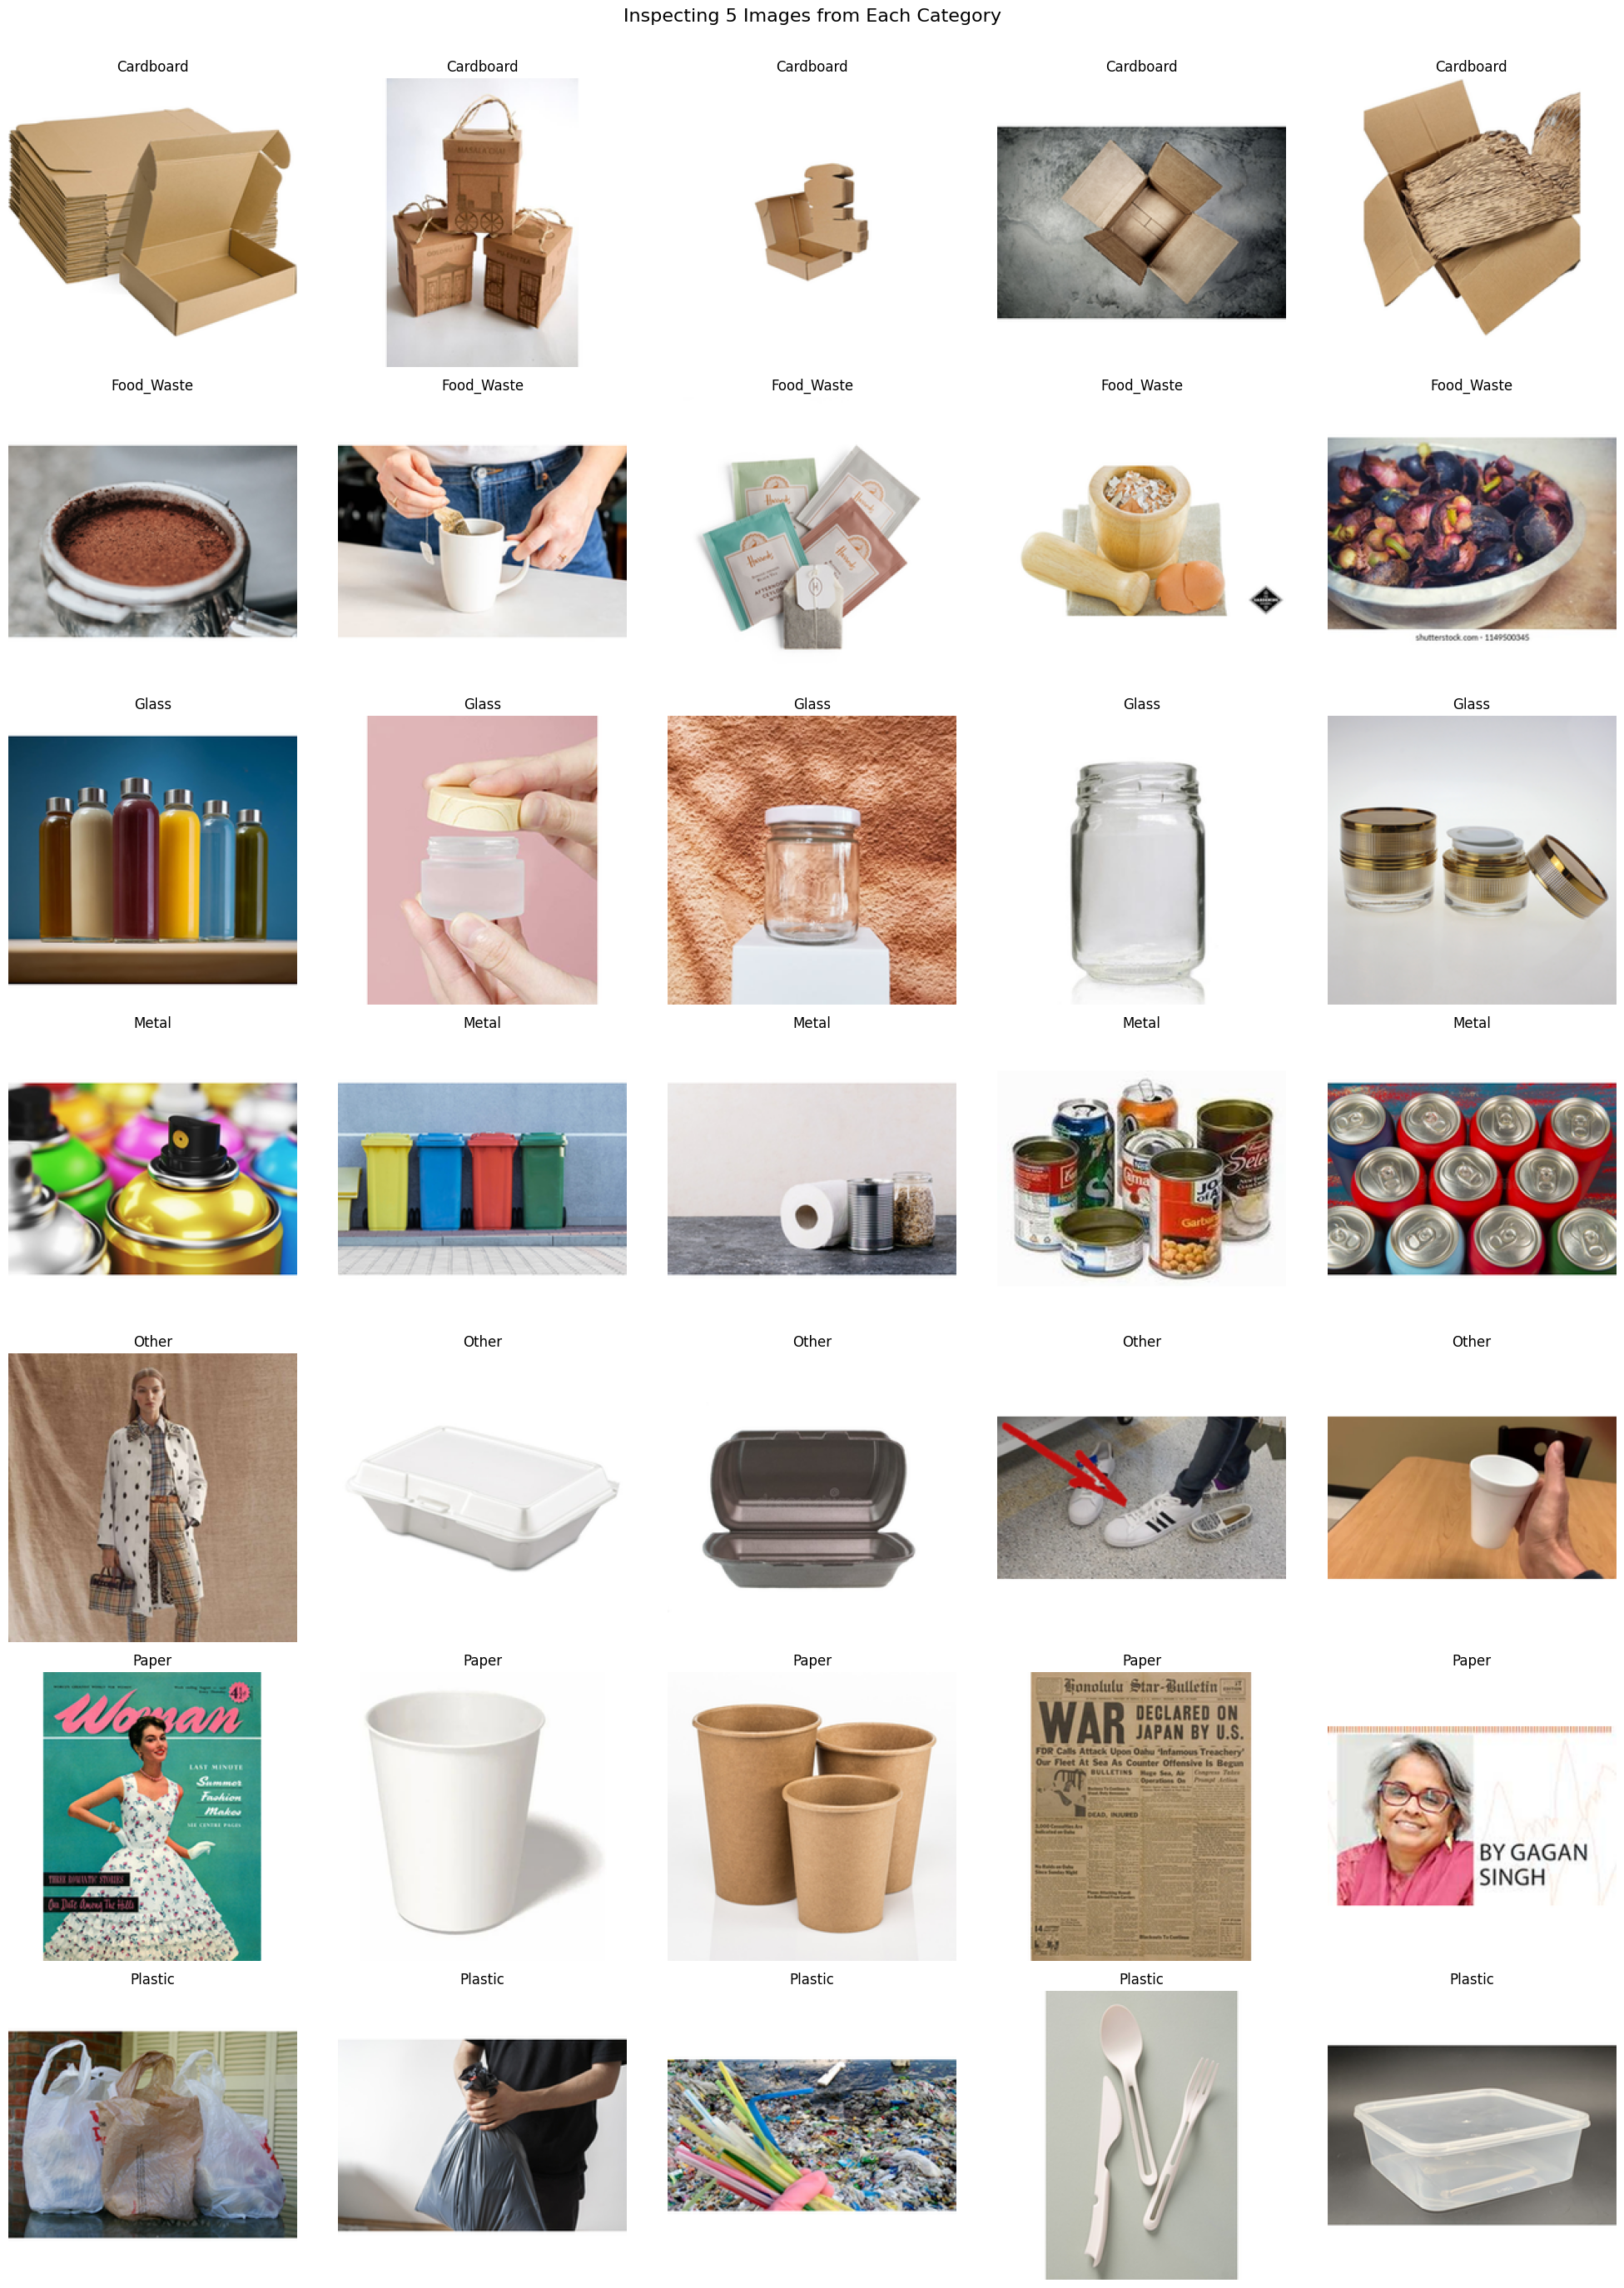

In [ ]:
# Get the images and their labels

def visualize_sample_images(data_dir, categories, images_per_category=2, target_size=(224, 224)):
    """
    Loads and displays a specified number of sample images per category.

    Parameters:
    - data_dir (str): Path to the dataset directory (where category subfolders are located).
    - categories (list): List of category folder names.
    - images_per_category (int): Number of sample images to load per category.
    - target_size (tuple): Target size to resize images to.
    """
    # Lists to hold the loaded images and labels
    images = []
    labels = []

    # Load images and labels for each category
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        image_count = 0 # Track how many images we've added per category
        for file in os.listdir(category_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(category_dir, file)
                image_array = load_and_crop_image(image_path, target_size=target_size)
                images.append(image_array)
                labels.append(category)
                image_count += 1
                if image_count == images_per_category:
                    break
    # Verify if the images and labels are loaded correctly
    print("Total images loaded:", len(images))
    print("Total labels loaded:", len(labels))
    print("Unique labels:", set(labels), '\n')

    # Plot the images
    # Display required no of images per category
    fig, axes = plt.subplots(nrows=len(categories), ncols=images_per_category, figsize=(images_per_category * 4, len(categories) * 4))
    fig.suptitle(f'Inspecting {images_per_category} Images from Each Category', fontsize=16)

    img_idx = 0
    for row_idx, category in enumerate(categories):
        for col_idx in range(images_per_category):
            ax = axes[row_idx, col_idx]
            ax.imshow(images[img_idx])
            ax.set_title(f"{category}")
            ax.axis('off')
            img_idx += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
visualize_sample_images(data_dir, categories, images_per_category=5, target_size=(224, 224))

**The images and their corresponding labels have been successfully loaded and displayed, confirming the integrity and correctness of the dataset.**

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

<ipython-input-116-67a4eb705040>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_counts, x='Category', y='Image Count', palette='viridis')


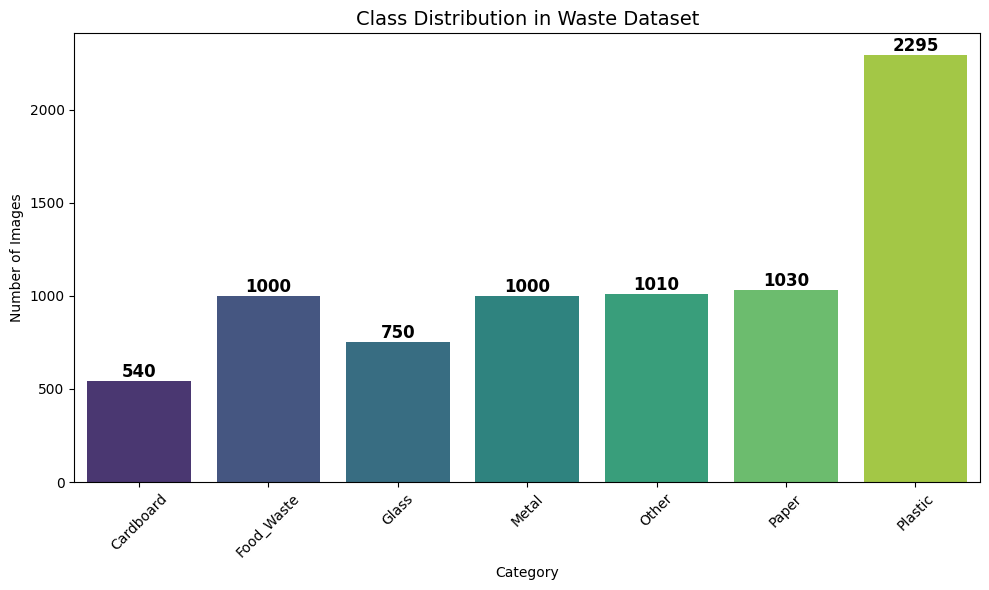

In [ ]:
# Visualise Data Distribution

def plot_image_distribution(data_dir, categories):
    """
    Plots a bar chart of image counts per category and annotates each bar with the count value.

    Parameters:
    - data_dir (str): Path to the main dataset directory.
    - categories (list): List of category (subfolder) names.
    """
    # Count images per category
    category_counts = {}
    for category in categories:
        category_path = os.path.join(data_dir, category)
        count = len([
            file for file in os.listdir(category_path)
            if file.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        category_counts[category] = count

    # Convert to DataFrame
    df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Image Count'])

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(data=df_counts, x='Category', y='Image Count', palette='viridis')

    # Annotate count values on top of each bar
    for p in barplot.patches:
        height = p.get_height()
        barplot.annotate(f'{int(height)}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title('Class Distribution in Waste Dataset', fontsize=14)
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_image_distribution(data_dir, categories)

- **Overall Distribution:**  
  The dataset comprises a total of **7625 images**.

- **Category Breakdown:**  
  - **Plastic:** 2295 images (~30% of the dataset)  
  - **Food_Waste:** 1000 images (~13%)  
  - **Metal:** 1000 images (~13%)  
  - **Other:** 1010 images (~13%)  
  - **Paper:** 1030 images (~13.5%)  
  - **Glass:** 750 images (~10%)  
  - **Cardboard:** 540 images (~7%)

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

Total images loaded: 14
Total labels loaded: 14
Unique labels: {'Metal', 'Other', 'Cardboard', 'Plastic', 'Paper', 'Food_Waste', 'Glass'} 



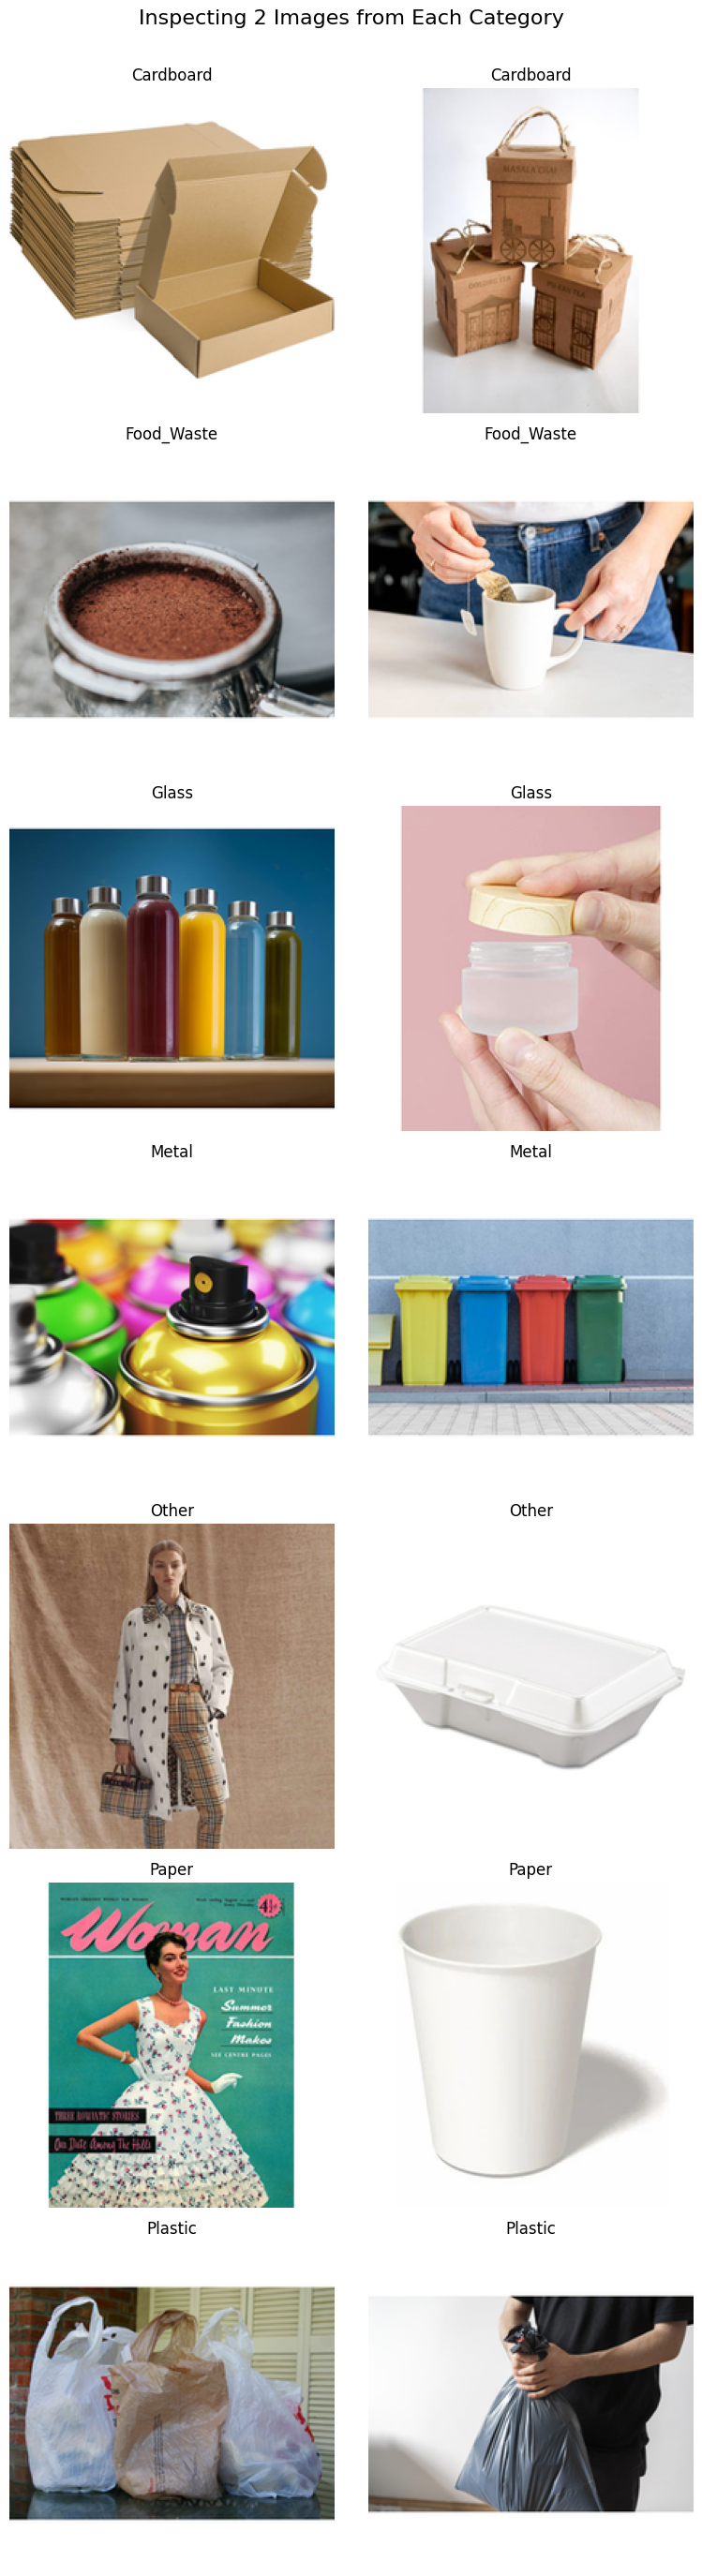

In [ ]:
# Visualise Sample Images (across different labels)

visualize_sample_images(data_dir, categories, images_per_category=2, target_size=(224, 224))

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set


def get_dimension_range(data_dir, categories):
    """
    Scans the dataset to find the smallest and largest image dimensions.

    Parameters:
    - data_dir (str): Base directory where category subfolders are located.
    - categories (list): List of category names (subfolder names).

    Returns:
    - min_width, min_height, max_width, max_height (tuple of ints):
      The smallest width and height and the largest width and height found.
    """
    # Initialize with extreme values
    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    # Loop over each category folder and each image file within it
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for file in os.listdir(category_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(category_path, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    # Update smallest dimensions
                    if width < min_width:
                        min_width = width
                    if height < min_height:
                        min_height = height
                    # Update largest dimensions
                    if width > max_width:
                        max_width = width
                    if height > max_height:
                        max_height = height

    return int(min_width), int(min_height), int(max_width), int(max_height)

min_width, min_height, max_width, max_height = get_dimension_range(data_dir, categories)

# Print values
print("Smallest image dimensions:", (min_width, min_height))
print("Largest image dimensions:", (max_width, max_height))

Smallest image dimensions: (256, 256)
Largest image dimensions: (256, 256)


All images in the dataset are of uniform size (256×256), as both min and max dimensions are identical.


**Resize images from (256×256) to (224×224) to standardize the input size for the CNN. This resizing optimizes computational efficiency, as smaller images require less memory and processing power. While resizing may reduce some image detail, this trade-off is generally acceptable for classification tasks, where overall patterns and features are more important than pixel-level precision.**

In [ ]:
# Resize the image dimensions

def resize_image(image_path, target_size):
    """
    Resizes an image to the specified target size.

    Parameters:
    - image_path (str): Path to the image file.
    - target_size (tuple of ints): Target size as (width, height).

    Returns:
    - np.array: The resized image as a NumPy array.
    """
    with Image.open(image_path) as img:
        # Resize using LANCZOS resampling for high-quality downsizing
        resized_img = img.resize(target_size, Image.Resampling.LANCZOS)
    return np.array(resized_img)

def load_and_resize_all_images(data_dir, categories, target_size):
    """
    Loads and resizes all images from the dataset based on the target size.

    Parameters:
    - data_dir (str): Base directory with category folders.
    - categories (list): List of category names.
    - target_size (tuple of ints): Desired image size as (width, height).

    Returns:
    - images (list of np.array): List containing all resized images.
    - labels (list): Corresponding list of category labels.
    """
    images = []
    labels = []
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        for file in os.listdir(category_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(category_dir, file)
                resized_img = resize_image(image_path, target_size)
                images.append(resized_img)
                labels.append(category)
    return images, labels

# Resize images from (256×256) to (224×224) to standardize the input size for the CNN.

target_size = (224, 224)
all_images, all_labels = load_and_resize_all_images(data_dir, categories, target_size)
print("Total images processed:", len(all_images))


Total images processed: 7625


In [ ]:
# Verify all images have been resized to the target size including channel dimension
heights = [img.shape[0] for img in all_images]
widths = [img.shape[1] for img in all_images]
channels = [img.shape[2] if len(img.shape) == 3 else 1 for img in all_images]  # Handle grayscale images

print("Minimum image size:", (min(widths), min(heights)))
print("Maximum image size:", (max(widths), max(heights)))
print("Unique channel dimensions:", set(channels))


Minimum image size: (224, 224)
Maximum image size: (224, 224)
Unique channel dimensions: {3}


**All images have been successfully resized to uniform dimensions of (224, 224, 3), confirming consistent width, height, and RGB channel format across the dataset.**


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably


# 'all_labels' is a list of string labels extracted from the dataset,
# ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']

# Encode the string labels to integer indices
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)

# Create a clean mapping dictionary
label_mapping = {str(label): int(index) for label, index in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}

# Print a cleaner mapping: label: corresponding integer index
print("Label mapping:")
for label, index in label_mapping.items():
    print(f"{label}: {index}")

# Convert integer encoded labels to one-hot encoded vectors for multi-class classification
one_hot_labels = to_categorical(integer_encoded)
print("Encoded labels shape:", one_hot_labels.shape)


Label mapping:
Cardboard: 0
Food_Waste: 1
Glass: 2
Metal: 3
Other: 4
Paper: 5
Plastic: 6
Encoded labels shape: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# Assign specified parts of the dataset to train and validation sets

# Split the dataset into training and validation sets
# Using stratify ensures that the class distribution remains similar in both splits.
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images,
    one_hot_labels,
    test_size=0.2,       # 20% of the data is reserved for validation
    random_state=42,     # Ensures reproducibility
    stratify=integer_encoded  # Preserves the original class distribution
)

# # Normalize and convert training and validation image lists to NumPy arrays
# Excluded normalization as it impacted the model performance
# train_images = np.array(train_images)/255
# val_images = np.array(val_images)/255

# Convert training and validation image lists to NumPy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)

# Print sizes of the splits to verify
print("Training set size:", len(train_images))
print("Validation set size:", len(val_images))

Training set size: 6100
Validation set size: 1525


In [ ]:
# Now reshape the arrays
train_images = train_images.reshape((6100, 224, 224, 3))
val_images = val_images.reshape((1525, 224, 224, 3))



## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# # Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 7  # For the seven waste categories

In [ ]:
# Define configurations - all with 3 convolutional layers and dropouts

# Note: In these configurations,
# CDR refers to conv_dropout_rates,
# DDR refers to dense_dropout_rate, and
# LR refers to learning_rate.

configurations = [

      {
        'name': 'Config 1 - RMSprop',
        'filters': [32, 64, 128],
        'kernel_size': (3, 3),
        'pool_size': (2, 2),
        'activation': 'relu',
        'conv_dropout_rates': [0.2, 0.2, 0.3],  # Varied CDR
        'dense_dropout_rate': 0.5,
        'dense_units': 128,
        'learning_rate': 0.00001,
        'optimizer': 'rmsprop'
      },

    # Config 2 was excluded because it consumed all the available RAM on Google Colab, resulting in a session crash.
    # {
    #     'name': 'Config 2 - Higher Filters',
    #     'filters': [64, 128, 256],  # 3 layers with higher filter counts
    #     'kernel_size': (3, 3),
    #     'pool_size': (2, 2),
    #     'activation': 'relu',
    #     'conv_dropout_rates': [0.15, 0.25, 0.35],  # Slightly higher dropout rates
    #     'dense_dropout_rate': 0.5,
    #     'dense_units': 256,
    #     'learning_rate': 0.0005,
    #     'optimizer': 'adam'
    # },

      {
            'name': 'Config 3 - Adam',
            'filters': [32, 64, 128],
            'kernel_size': (3, 3),
            'pool_size': (2, 2),
            'activation': 'relu',
            'conv_dropout_rates': [0.1, 0.1, 0.1],  # Uniform CDR
            'dense_dropout_rate': 0.5,
            'dense_units': 128,
            'learning_rate': 0.0001,
            'optimizer': 'adam'
        },
        {
            'name': 'Config 4 - Adam|LR=1e-5|Varied CDR',
            'filters': [32, 64, 128],
            'kernel_size': (3, 3),
            'pool_size': (2, 2),
            'activation': 'relu',
            'conv_dropout_rates': [0.1, 0.2, 0.2],  # Varied CDR
            'dense_dropout_rate': 0.5,
            'dense_units': 128,
            'learning_rate': 0.00001,
            'optimizer': 'adam'
        },
        {
            'name': 'Config 5 - Adam|LR=1e-6|High CDR',
            'filters': [32, 64, 128],
            'kernel_size': (3, 3),
            'pool_size': (2, 2),
            'activation': 'relu',
            'conv_dropout_rates': [0.3, 0.3, 0.3],  # Higher CDR
            'dense_dropout_rate': 0.5,
            'dense_units': 128,
            'learning_rate': 0.000001,              # Lower LR
            'optimizer': 'adam'
        },
        {
            'name': 'Config 6 - Adam|LR=1e-6|Lower DDR',
            'filters': [32, 64, 128],
            'kernel_size': (3, 3),
            'pool_size': (2, 2),
            'activation': 'relu',
            'conv_dropout_rates': [0.1, 0.1, 0.2],
            'dense_dropout_rate': 0.45,            # Lower DDR
            'dense_units': 128,
            'learning_rate': 0.000001,             # Lower LR
            'optimizer': 'adam'
        },

]


def create_cnn_model(config, input_shape, num_classes):
    """
    Create a CNN model with 3 convolutional layers, each with dropout after each conv layer.

    Args:
        config: Dictionary containing model configuration.
        input_shape: Shape of input images (height, width, channels).
        num_classes: Number of classes for classification.

    Returns:
        Compiled Keras model.
    """
    model = Sequential()

    # First convolutional layer with Batch Normalization and dropout
    model.add(Conv2D(config['filters'][0],
                     config['kernel_size'],
                     activation=config['activation'],
                     padding='same',                  # 'same' padding preserves spatial dimensions
                     input_shape=input_shape,
                     #kernel_regularizer=l2(0.01) # Excluded l2 regularization from all Conv layers since it didn't improve model performance
                     ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=config['pool_size']))
    model.add(Dropout(config['conv_dropout_rates'][0]))  # Dropout after first conv layer

    # Second convolutional layer with Batch Normalization and dropout
    model.add(Conv2D(config['filters'][1],
                     config['kernel_size'],
                     activation=config['activation'],
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=config['pool_size']))
    model.add(Dropout(config['conv_dropout_rates'][1]))  # Dropout after second conv layer

    # Third convolutional layer with Batch Normalization and dropout
    model.add(Conv2D(config['filters'][2],
                     config['kernel_size'],
                     activation=config['activation'],
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=config['pool_size']))
    model.add(Dropout(config['conv_dropout_rates'][2]))  # Dropout after third conv layer

    # Flatten the output
    model.add(Flatten())

    # Global Max Pooling instead of Flatten (Excluded)
    # model.add(GlobalMaxPooling2D())

    # Add dense layer with L2 regularization
    model.add(Dense(config['dense_units'],
                activation=config['activation'],
                kernel_regularizer=l2(0.1)))  # L2 regularization with factor 0.1
    model.add(Dropout(config['dense_dropout_rate']))  # Dropout before the output layer


    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Configure optimizer
    if config['optimizer'].lower() == 'adam':
        optimizer = Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'].lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=config['learning_rate'])
    elif config['optimizer'].lower() == 'sgd':
        optimizer = SGD(learning_rate=config['learning_rate'])
    else:
        optimizer = Adam(learning_rate=config['learning_rate'])

    # Compile model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Iterate over each configuration, create and compile its model,
# then display the model summary for inspection.
for config in configurations:
    print(f"Creating model for configuration: {config['name']}")
    model = create_cnn_model(config, input_shape, num_classes)
    # Display the compiled model summary
    print("\nCompiled Model Summary for", config['name'])
    model.summary()
    print("="*75, "\n")

Creating model for configuration: Config 1 - RMSprop

Compiled Model Summary for Config 1 - RMSprop


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_123 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_123               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_124               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_125               │ (None, 28, 28, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,231 (49.36 MB)

 Trainable params: 12,939,783 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)


Creating model for configuration: Config 3 - Adam

Compiled Model Summary for Config 3 - Adam


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_126 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_126         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_126               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_127         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_127               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_128         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_128               │ (None, 28, 28, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,231 (49.36 MB)

 Trainable params: 12,939,783 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)


Creating model for configuration: Config 4 - Adam|LR=1e-5|Varied CDR

Compiled Model Summary for Config 4 - Adam|LR=1e-5|Varied CDR


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_129 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_129         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_129               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_130         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_130               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_131         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_131               │ (None, 28, 28, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,231 (49.36 MB)

 Trainable params: 12,939,783 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)


Creating model for configuration: Config 5 - Adam|LR=1e-6|High CDR

Compiled Model Summary for Config 5 - Adam|LR=1e-6|High CDR


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_132 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_132               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_133               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_134               │ (None, 28, 28, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,231 (49.36 MB)

 Trainable params: 12,939,783 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)


Creating model for configuration: Config 6 - Adam|LR=1e-6|Lower DDR

Compiled Model Summary for Config 6 - Adam|LR=1e-6|Lower DDR


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_135 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_135         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_135               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_136               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_137               │ (None, 28, 28, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,231 (49.36 MB)

 Trainable params: 12,939,783 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
# Training

def train_cnn_models(configurations, train_images, train_labels, val_images, val_labels,
                 epochs=10, batch_size=32):
    """
    Train models using multiple configurations

    Args:
        configurations: List of configuration dictionaries
        train_images, train_labels: Training data
        val_images, val_labels: Validation data
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        Dictionary with trained models and training history for each configuration
    """
    trained_cnn_models = {}
    input_shape = train_images.shape[1:]
    num_classes = train_labels.shape[1]

    for config in configurations:
        print(f"\n\n{'=' * 50} Training {config['name']} {'=' * 50}\n")

        # Create model based on configuration
        model = create_cnn_model(config, input_shape, num_classes)

        # Set up callbacks
        log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + config['name'].replace(" ", "_"))

        reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,
                                  patience=3,
                                  verbose=1,
                                  min_lr=1e-7)

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ModelCheckpoint(filepath=f"best_model_{config['name'].replace(' ', '_')}.keras",
                            monitor='val_accuracy', save_best_only=True),
            TensorBoard(log_dir=log_dir, histogram_freq=1),
            #reduce_lr
        ]

        # Train the model
        history = model.fit(
            train_images, train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_images, val_labels),
            callbacks=callbacks
        )

        # Store trained model and history
        trained_cnn_models[config['name']] = {
            'model': model,
            'history': history.history
        }

        # Plot training history
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Training and Validation Accuracy - {config["name"]}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training and Validation Loss - {config["name"]}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"training_plot_{config['name'].replace(' ', '_')}.png")
        plt.show()

    return trained_cnn_models



================================================== Training Config 1 - RMSprop ==================================================

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.2316 - loss: 27.9627 - val_accuracy: 0.3174 - val_loss: 24.7910
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.3118 - loss: 23.7291 - val_accuracy: 0.3830 - val_loss: 20.1041
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.3502 - loss: 19.1663 - val_accuracy: 0.3797 - val_loss: 16.2688
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.3824 - loss: 15.5517 - val_accuracy: 0.4138 - val_loss: 13.4893
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4043 - loss: 13.0490 - val_accuracy: 0.4597 - val_loss: 11.6719
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.4290 - loss: 11.4203 - val_accuracy: 0.4616 - val_loss: 10.5605
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4470 - 

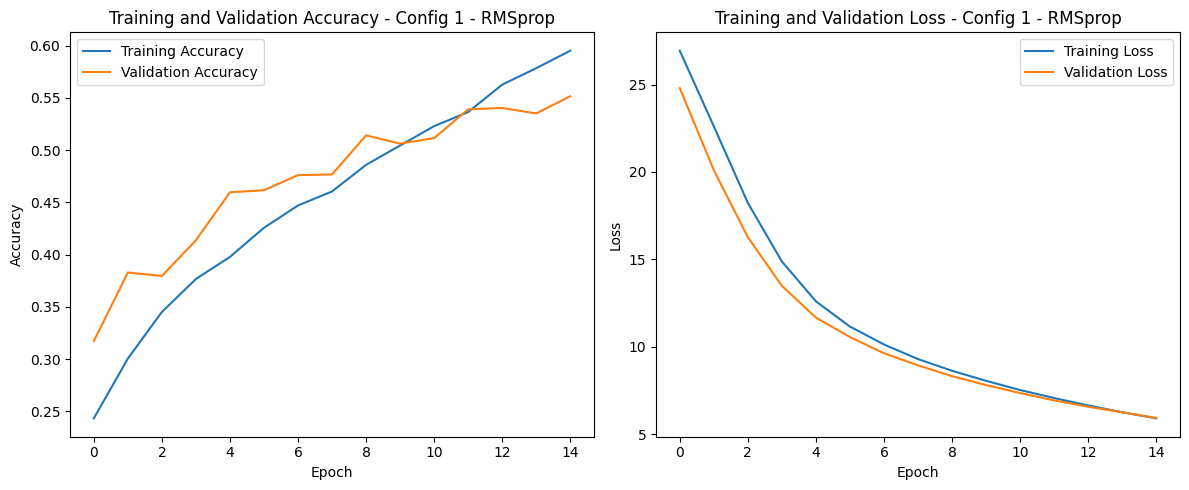



================================================== Training Config 3 - Adam ==================================================

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - accuracy: 0.2768 - loss: 23.3776 - val_accuracy: 0.3069 - val_loss: 10.4537
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.2991 - loss: 8.7770 - val_accuracy: 0.3075 - val_loss: 5.0775
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.3067 - loss: 4.5252 - val_accuracy: 0.2944 - val_loss: 3.1937
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.3095 - loss: 3.0351 - val_accuracy: 0.2879 - val_loss: 2.5249
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.3091 - loss: 2.4375 - val_accuracy: 0.3115 - val_loss: 2.1910
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.3136 - loss: 2.2105 - val_accuracy: 0.3128 - val_loss: 2.1146
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3204 - loss: 2.1586 

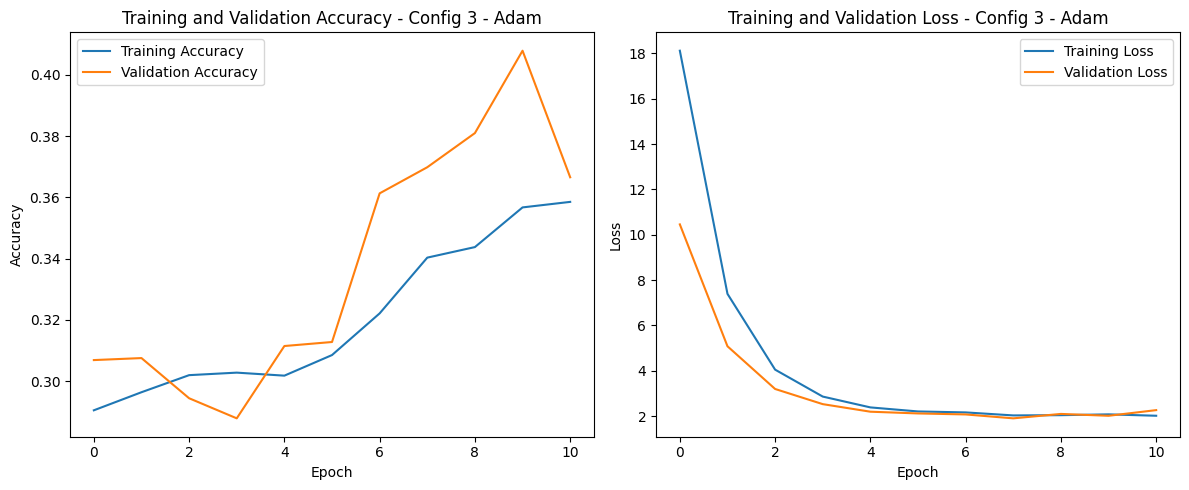



================================================== Training Config 4 - Adam|LR=1e-5|Varied CDR ==================================================

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.2356 - loss: 27.6761 - val_accuracy: 0.3928 - val_loss: 25.7596
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.3172 - loss: 25.3132 - val_accuracy: 0.4315 - val_loss: 23.5507
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.3562 - loss: 23.0970 - val_accuracy: 0.4302 - val_loss: 21.3540
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.3831 - loss: 20.8706 - val_accuracy: 0.4662 - val_loss: 19.2064
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4276 - loss: 18.7560 - val_accuracy: 0.4630 - val_loss: 17.2804
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4362 - loss: 16.8486 - val_accuracy: 0.4918 - val_loss: 15.4891
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - acc

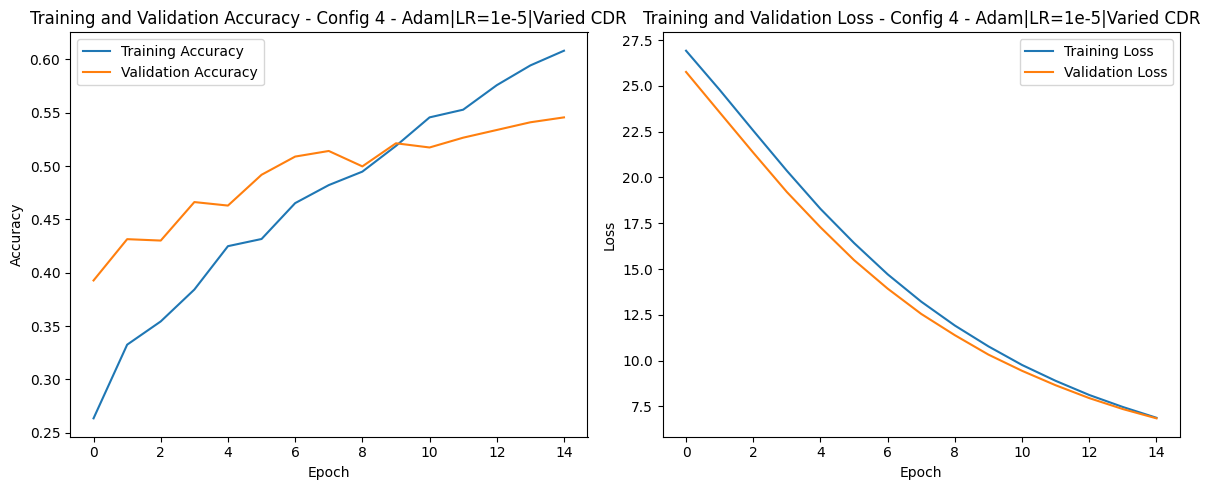



================================================== Training Config 5 - Adam|LR=1e-6|High CDR ==================================================

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.1672 - loss: 29.7803 - val_accuracy: 0.1757 - val_loss: 27.5290
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2035 - loss: 28.3216 - val_accuracy: 0.1882 - val_loss: 27.4850
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2204 - loss: 27.7677 - val_accuracy: 0.1934 - val_loss: 27.4024
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2392 - loss: 27.4342 - val_accuracy: 0.2046 - val_loss: 27.3126
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2426 - loss: 27.2717 - val_accuracy: 0.2184 - val_loss: 27.2089
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.2468 - loss: 27.1123 - val_accuracy: 0.2315 - val_loss: 27.1174
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accur

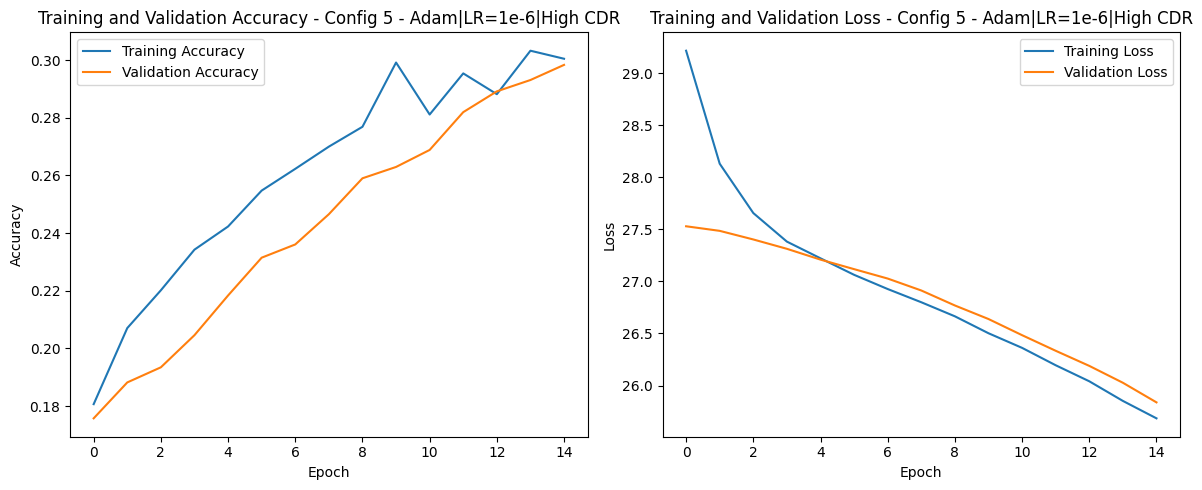



================================================== Training Config 6 - Adam|LR=1e-6|Lower DDR ==================================================

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.1796 - loss: 29.1589 - val_accuracy: 0.2695 - val_loss: 27.3939
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2260 - loss: 28.0665 - val_accuracy: 0.3134 - val_loss: 27.2216
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2450 - loss: 27.6414 - val_accuracy: 0.3344 - val_loss: 27.1052
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.2697 - loss: 27.3431 - val_accuracy: 0.3416 - val_loss: 26.9927
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.2579 - loss: 27.1899 - val_accuracy: 0.3469 - val_loss: 26.8781
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.2968 - loss: 26.9993 - val_accuracy: 0.3593 - val_loss: 26.7555
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accu

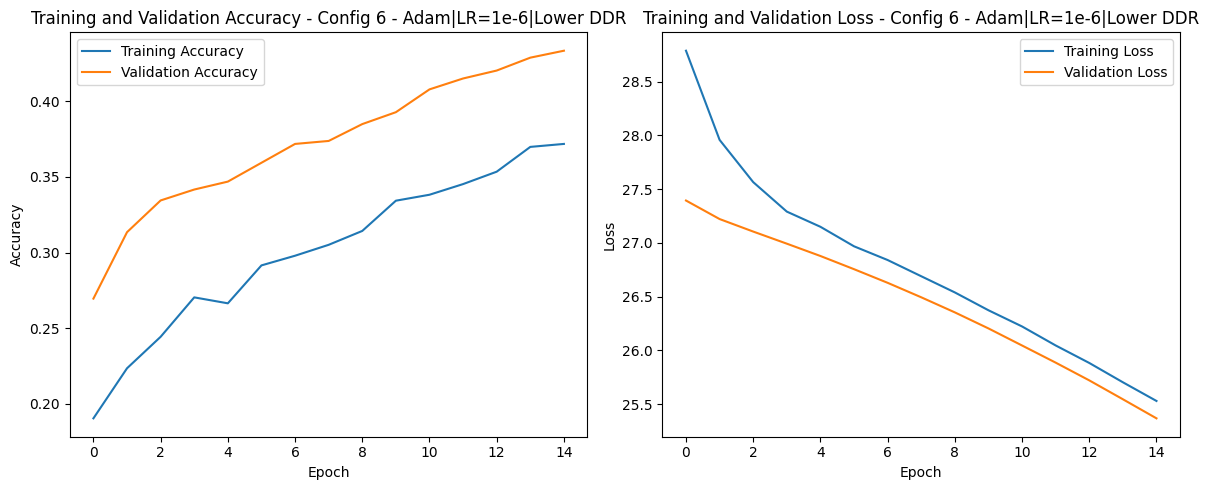

In [ ]:
# Train all configurations with 15 epochs
trained_cnn_models = train_cnn_models(
    configurations,
    train_images,
    train_labels,
    val_images,
    val_labels,
    epochs=15,
    batch_size=32
)


**Overall Model Performance:**

- **Training Dynamics:**  
  Across the different configurations, we observed that the models generally improved their training accuracy over epochs. For instance, Config 1 – RMSprop increased from 23% to nearly 59%, and Config 4 improved from 23% to nearly 60% training accuracy over 15 epochs. However, validation accuracy consistently ranged from about 49% to 56%, while training accuracy was notably higher.

  Config 2, using higher filter counts [64, 128, 256] across three convolutional layers, was excluded due to excessive RAM usage on Google Colab, which led to a session crash every time.

- **Best Configuration:**  
  Among the configurations tested, **Config 1 – RMSprop** with `RMPprop optimizer` and **Config 4 - Adam|LR=1e-5|Varied CDR** with `Adam Optimizer` achieved the highest test accuracy (~55-56%). Even though the validation accuracy plateaued around 55% in these configurations, it was marginally better than or comparable to the others.  
  The classification report for this configuration shows moderate precision and recall values across classes, with noticeable variability. For example, while some classes (e.g., class 6) attain higher precision and recall, others (like class 2) exhibit higher recall but lower precision.
  

- **Underperforming Configurations:**  
  Config 5 - Higher CDR performed particularly poorly (with test accuracy around 29%), suggesting that too high a dropout rate in convolutional layers can hinder the learning of essential features, thereby hurting performance.



**Challenges and Future Directions:**

- **Overfitting vs. Underfitting:**  
  The gap between the training (up to ~59–62%) and validation accuracies (around ~53–55%) across models indicates that some degree of overfitting persists. Although regularization techniques such as dropout and batch normalization were applied, further strategies (such as more aggressive or targeted data augmentation, fine-tuning dropout rates, and employing transfer learning) might be necessary to push validation accuracy beyond 60%.

- **Hyperparameter Tuning:**  
  The different configurations tested (varying optimizers, learning rates, dropout rates, and layer complexities) provided valuable insights. For example, lowering the learning rate in Config 4 stabilized the training process, but overall accuracy improvements might require additional hyperparameter adjustments.

---

### Observations:

While the best configuration (Config 1 / Config 4) achieved around 56% test accuracy, the findings highlight important areas for improvement in handling class imbalance and enhancing generalization. The training experiments underscore the need for further fine-tuning of hyperparameters, additional data augmentation, and possibly exploring alternative modeling approaches (like transfer learning) to achieve a validation accuracy of 60% or higher without overfitting.


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics
def evaluate_cnn_models(trained_cnn_models, val_images, val_labels):
    """
    Evaluate trained models on test data

    Args:
        trained_cnn_models: Dictionary with trained models for each configuration
        val_images, val_labels: Validation data

    Returns:
        Dictionary with evaluation results for each configuration
    """
    results = {}

    for name, model_data in trained_cnn_models.items():
        model = model_data['model']
        history = model_data['history']

        print(f"\n\n=== Evaluating {name} ===\n")

        # Evaluate on test set
        test_loss, test_accuracy = model.evaluate(val_images, val_labels)
        print(f"\nTest accuracy for {name}: {test_accuracy:.4f}")

        # Make predictions
        predictions = model.predict(val_images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(val_labels, axis=1)

        # Classification report
        report = classification_report(true_classes, predicted_classes, zero_division=0)
        print(f"\nClassification Report for {name}:")
        print(report)

        # Confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        print(f"\nConfusion Matrix for {name}:")
        print(cm)

        # Store results
        results[name] = {
            'model': model,
            'history': history,
            'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'classification_report': report,
            'confusion_matrix': cm
        }

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - {name}')
        plt.colorbar()

        # Add class labels
        classes = [label for label in categories]
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(f"confusion_matrix_{name.replace(' ', '_')}.png")
        plt.show()

    return results

def visualize_model_results(results):
    """
    Visualize and compare results across configurations

    Args:
        results: Dictionary with results for each configuration
    """
    config_names = list(results.keys())
    test_accuracies = [results[name]['test_accuracy'] for name in config_names]

    # Plot test accuracies
    plt.figure(figsize=(10, 8))
    bars = plt.bar(config_names, test_accuracies)
    plt.title('Test Accuracy Across Configurations')
    plt.xlabel('Configuration')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=20)

    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("configuration_comparison.png")
    plt.show()

    # Plot training history for all configurations
    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 1, 1)
    for name in config_names:
        plt.plot(results[name]['history']['accuracy'], label=f'{name} - Training')
        plt.plot(results[name]['history']['val_accuracy'], linestyle='--', label=f'{name} - Validation')

    plt.title('Training and Validation Accuracy Across Configurations')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    for name in config_names:
        plt.plot(results[name]['history']['loss'], label=f'{name} - Training')
        plt.plot(results[name]['history']['val_loss'], linestyle='--', label=f'{name} - Validation')

    plt.title('Training and Validation Loss Across Configurations')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_comparison.png")
    plt.show()

def find_best_config(results):
    """
    Find the configuration with the best test accuracy

    Args:
        results: Dictionary with results for each configuration

    Returns:
        Name of the best configuration and its accuracy
    """
    best_config = None
    best_accuracy = 0

    for name, result in results.items():
        if result['test_accuracy'] > best_accuracy:
            best_accuracy = result['test_accuracy']
            best_config = name

    return best_config, best_accuracy





=== Evaluating Config 1 - RMSprop ===

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5569 - loss: 5.9111

Test accuracy for Config 1 - RMSprop: 0.5515
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report for Config 1 - RMSprop:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       108
           1       0.54      0.71      0.61       200
           2       0.53      0.55      0.54       150
           3       0.49      0.40      0.44       200
           4       0.43      0.47      0.44       202
           5       0.57      0.40      0.47       206
           6       0.64      0.63      0.64       459

    accuracy                           0.55      1525
   macro avg       0.54      0.54      0.53      1525
weighted avg       0.55      0.55      0.55      1525


Confusion Matrix for Config 1 - RMSprop:
[[ 71  13   4   4   5   2   9]
 [ 15 142   6   6  13   5  13]
 [  4   8  82   7  18   3  28]
 [  9  25  13  79  2

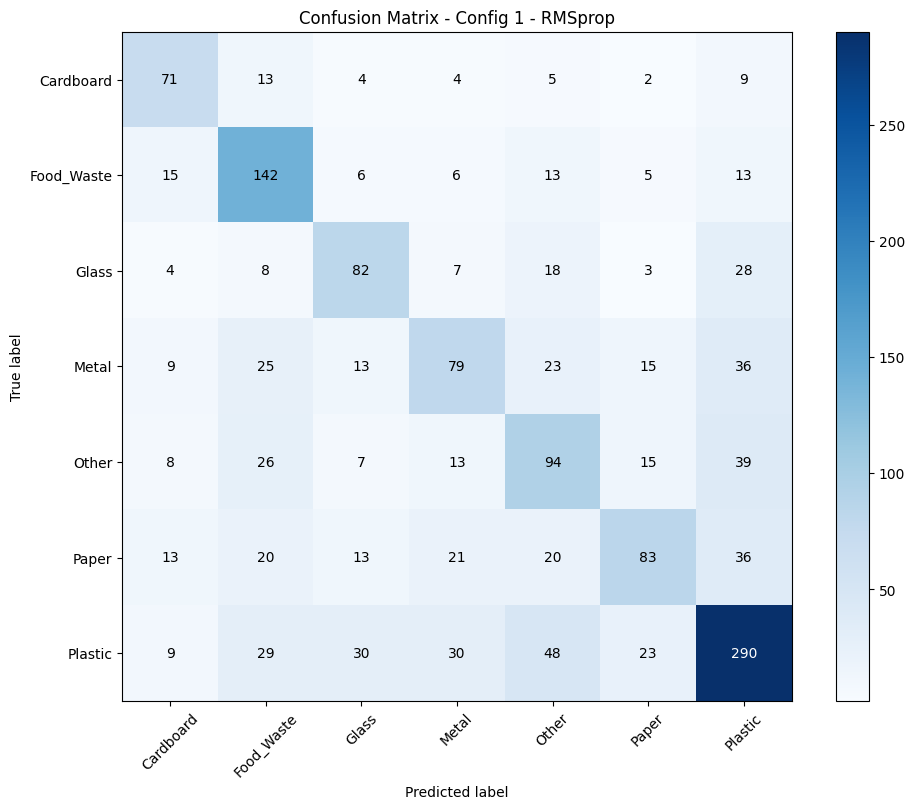



=== Evaluating Config 3 - Adam ===

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3644 - loss: 1.9029

Test accuracy for Config 3 - Adam: 0.3698
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report for Config 3 - Adam:
              precision    recall  f1-score   support

           0       0.32      0.53      0.40       108
           1       0.41      0.34      0.37       200
           2       0.00      0.00      0.00       150
           3       0.67      0.02      0.04       200
           4       0.83      0.02      0.05       202
           5       0.00      0.00      0.00       206
           6       0.37      0.94      0.53       459

    accuracy                           0.37      1525
   macro avg       0.37      0.26      0.20      1525
weighted avg       0.38      0.37      0.25      1525


Confusion Matrix for Config 3 - Adam:
[[ 57  19   0   0   0   0  32]
 [ 58  67   0   0   0   0  75]
 [ 10   5   0   1   1   0 133]
 [ 18  21   0   4   0   0 157]
 

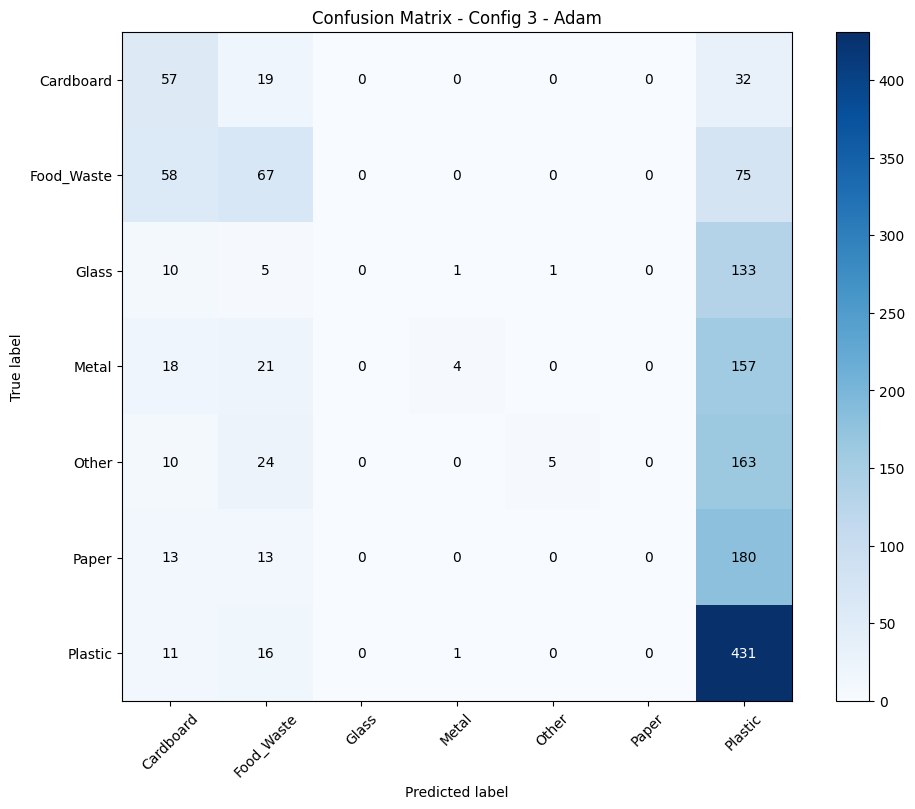



=== Evaluating Config 4 - Adam|LR=1e-5|Varied CDR ===

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5447 - loss: 6.8465

Test accuracy for Config 4 - Adam|LR=1e-5|Varied CDR: 0.5456
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report for Config 4 - Adam|LR=1e-5|Varied CDR:
              precision    recall  f1-score   support

           0       0.49      0.74      0.59       108
           1       0.55      0.68      0.60       200
           2       0.38      0.75      0.50       150
           3       0.51      0.47      0.49       200
           4       0.53      0.43      0.47       202
           5       0.68      0.33      0.45       206
           6       0.69      0.56      0.61       459

    accuracy                           0.55      1525
   macro avg       0.55      0.56      0.53      1525
weighted avg       0.58      0.55      0.54      1525


Confusion Matrix for Config 4 - Adam|LR=1e-5|Varied CDR:
[[ 80   6   9   4   3   3   3]
 [ 27 135  12   9 

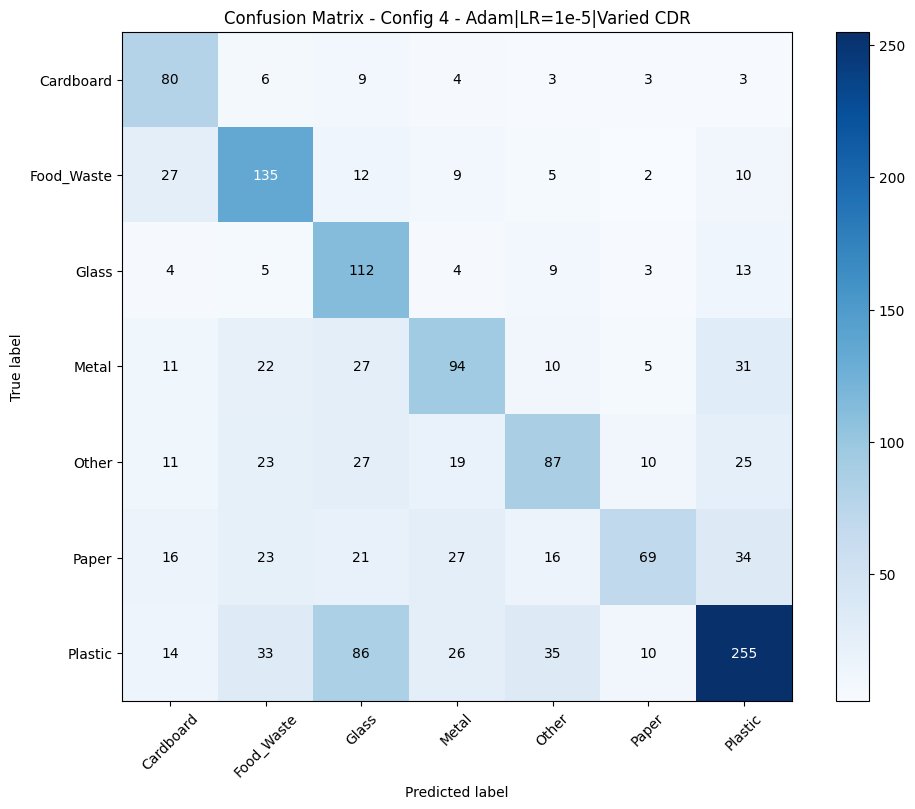



=== Evaluating Config 5 - Adam|LR=1e-6|High CDR ===

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3295 - loss: 25.8050

Test accuracy for Config 5 - Adam|LR=1e-6|High CDR: 0.2984
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Classification Report for Config 5 - Adam|LR=1e-6|High CDR:
              precision    recall  f1-score   support

           0       0.28      0.11      0.16       108
           1       0.37      0.43      0.40       200
           2       0.17      0.19      0.18       150
           3       0.23      0.05      0.08       200
           4       0.18      0.57      0.28       202
           5       0.56      0.23      0.33       206
           6       0.48      0.34      0.40       459

    accuracy                           0.30      1525
   macro avg       0.32      0.28      0.26      1525
weighted avg       0.36      0.30      0.29      1525


Confusion Matrix for Config 5 - Adam|LR=1e-6|High CDR:
[[ 12   6  22   2  55   1  10]
 [ 10  87  16   3  50   8

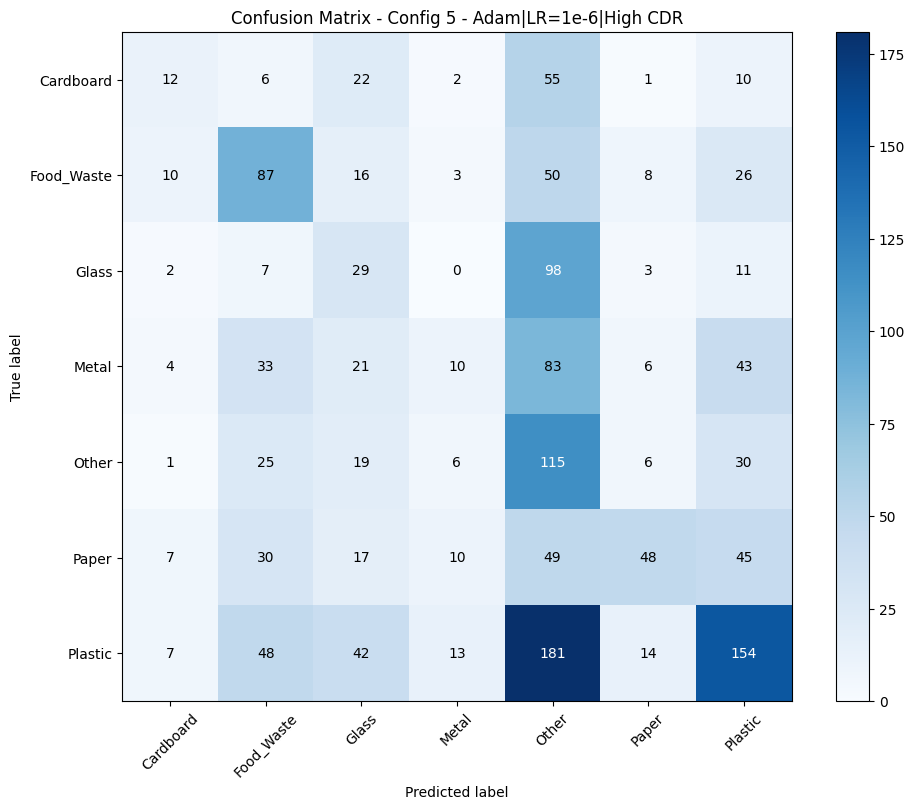



=== Evaluating Config 6 - Adam|LR=1e-6|Lower DDR ===

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4368 - loss: 25.3650

Test accuracy for Config 6 - Adam|LR=1e-6|Lower DDR: 0.4334
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report for Config 6 - Adam|LR=1e-6|Lower DDR:
              precision    recall  f1-score   support

           0       0.47      0.48      0.48       108
           1       0.46      0.54      0.49       200
           2       0.33      0.43      0.37       150
           3       0.35      0.16      0.22       200
           4       0.42      0.20      0.27       202
           5       0.46      0.30      0.36       206
           6       0.46      0.66      0.54       459

    accuracy                           0.43      1525
   macro avg       0.42      0.40      0.39      1525
weighted avg       0.43      0.43      0.41      1525


Confusion Matrix for Config 6 - Adam|LR=1e-6|Lower DDR:
[[ 52   9   7   0   5   5  30]
 [ 17 108   8   6   7

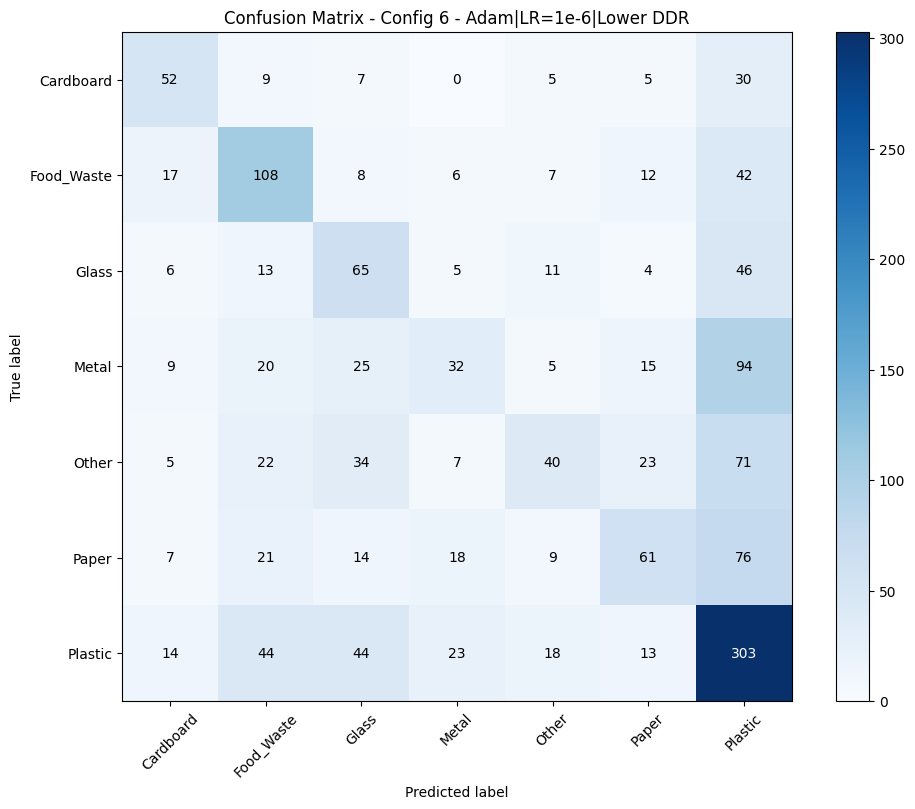

In [ ]:
# 3.2.1 Evaluate the models
results = evaluate_cnn_models(trained_cnn_models, val_images, val_labels)


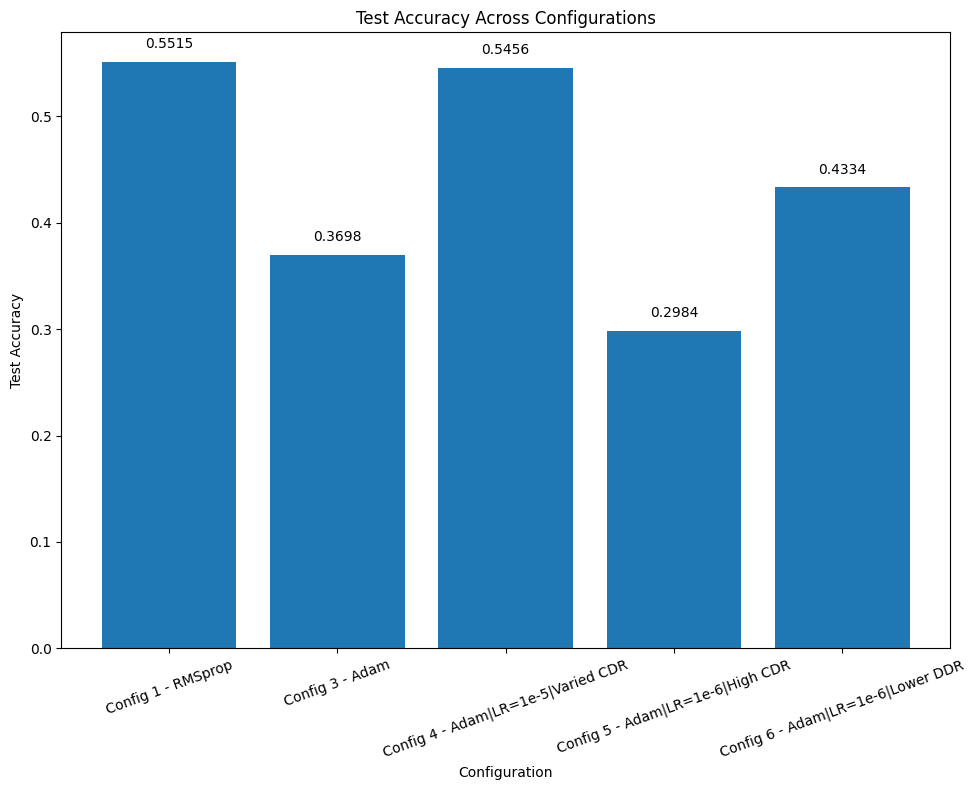

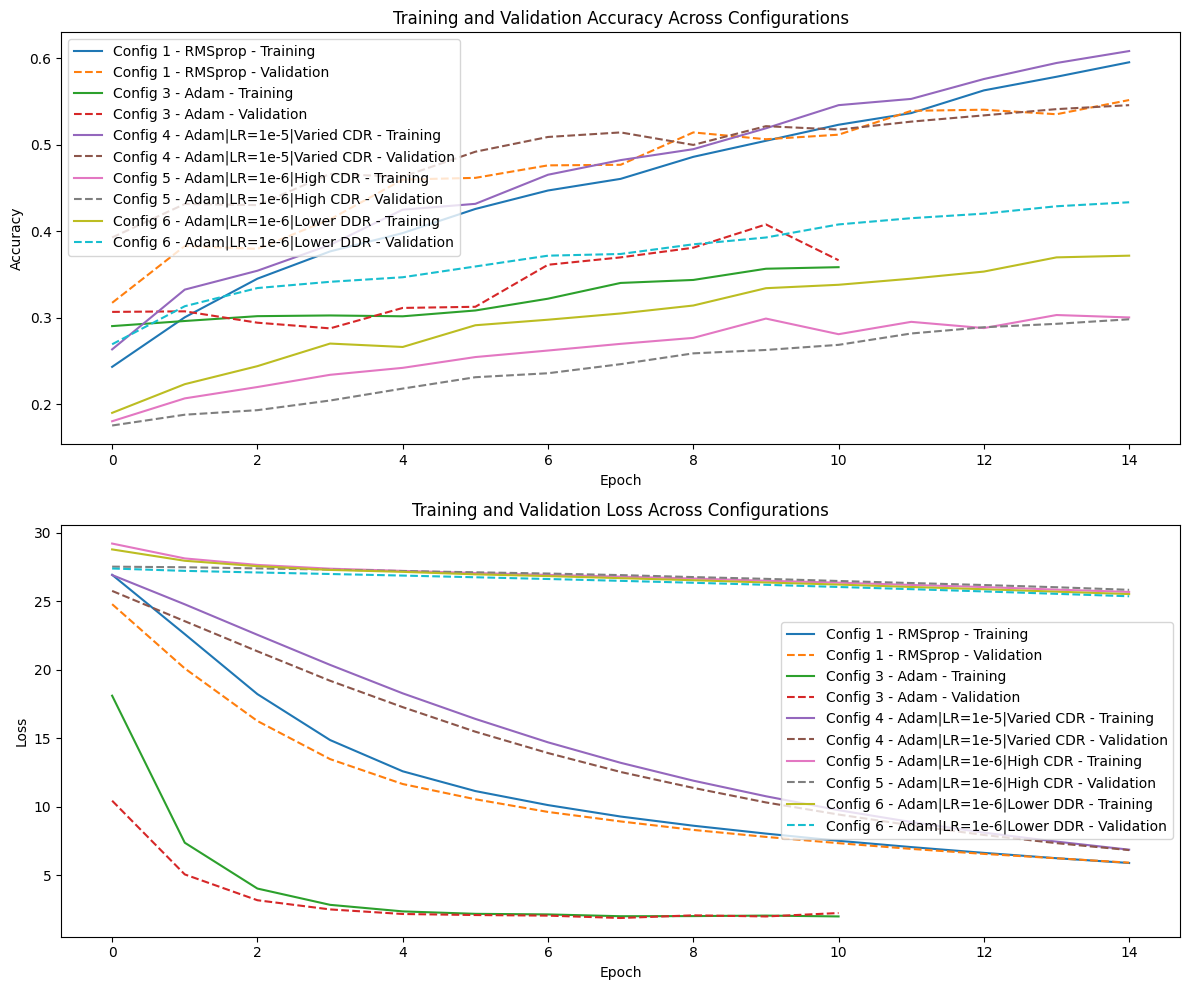

In [ ]:
# Visualize results across configurations
visualize_model_results(results)


In [ ]:
# Find the best configuration
best_config, best_accuracy = find_best_config(results)
print(f"Best configuration: {best_config} with test accuracy: {best_accuracy:.4f}")


Best configuration: Config 1 - RMSprop with test accuracy: 0.5515


In [ ]:
# Get the best model
best_model = results[best_config]['model']
best_model

<Sequential name=sequential_46, built=True>

In [ ]:
# Save the best model
best_model.save('waste_segregation_best_model.keras')

In [ ]:
# To analyze the performance per class:
best_report = results[best_config]['classification_report']
print("Classification Report for the Best Model:")
print(best_report)

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       108
           1       0.54      0.71      0.61       200
           2       0.53      0.55      0.54       150
           3       0.49      0.40      0.44       200
           4       0.43      0.47      0.44       202
           5       0.57      0.40      0.47       206
           6       0.64      0.63      0.64       459

    accuracy                           0.55      1525
   macro avg       0.54      0.54      0.53      1525
weighted avg       0.55      0.55      0.55      1525





================================================== Training Config 1 - RMSprop ==================================================



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.2303 - loss: 27.8235 - val_accuracy: 0.3521 - val_loss: 24.4038
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.3095 - loss: 23.2356 - val_accuracy: 0.3836 - val_loss: 19.4639
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.3465 - loss: 18.5304 - val_accuracy: 0.3967 - val_loss: 15.7728
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.3811 - loss: 15.1060 - val_accuracy: 0.4295 - val_loss: 13.1930
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.3972 - loss: 12.8007 - val_accuracy: 0.4374 - val_loss: 11.6415
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.4053 - loss: 11.3964 - val_accuracy: 0.4570 - val_loss: 10.5288
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4287 - loss: 10.3387 - val_accuracy: 0.4643 - val_loss: 9.7689
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.4570 - lo

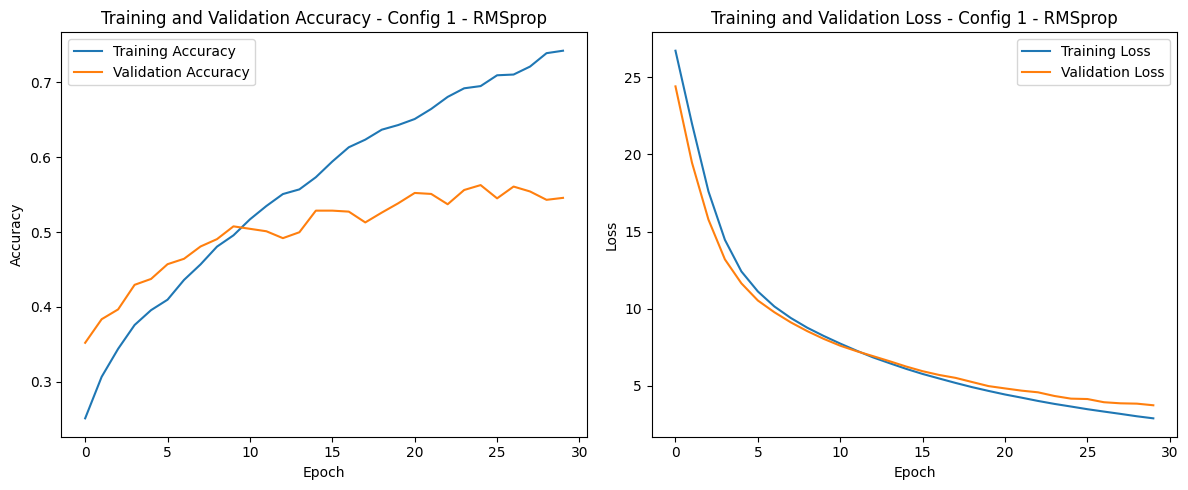



================================================== Training Config 4 - Adam|LR=1e-5|Varied CDR ==================================================

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.2160 - loss: 27.9787 - val_accuracy: 0.3292 - val_loss: 26.0998
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2908 - loss: 25.7580 - val_accuracy: 0.3810 - val_loss: 24.3377
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.3336 - loss: 23.9747 - val_accuracy: 0.4125 - val_loss: 22.5202
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.3660 - loss: 22.1378 - val_accuracy: 0.4420 - val_loss: 20.7016
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4044 - loss: 20.3077 - val_accuracy: 0.4485 - val_loss: 18.9366
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.4126 - loss: 18.5682 - val_accuracy: 0.4636 - val_loss: 17.3546
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - acc

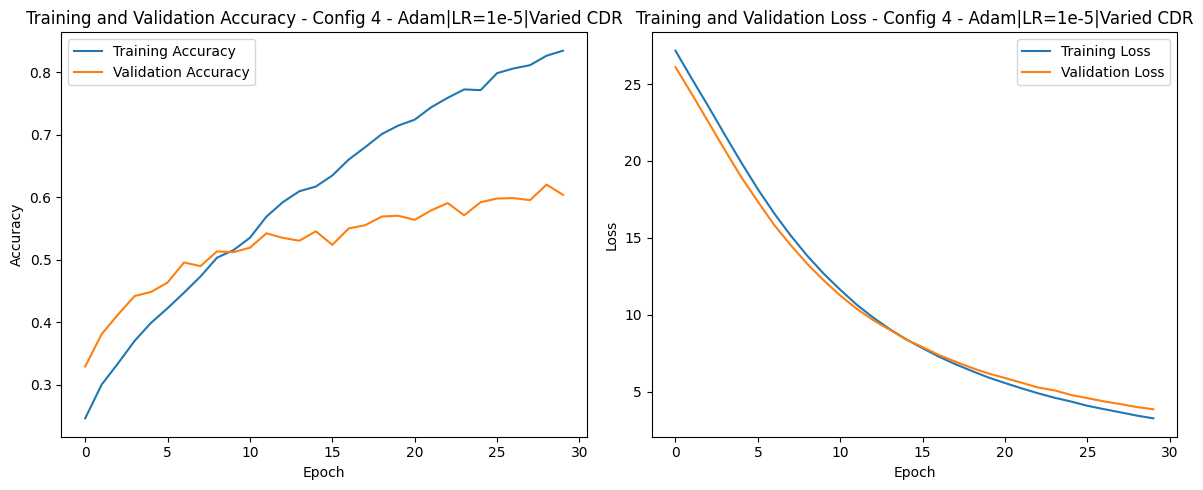

In [ ]:
# Train the top 2 best configurations 1 and 4 with higher 30 epochs to see if it improves the train and validation accuracy

config_1_4 = [configurations[0], configurations[2]]

trained_cnn_models = train_cnn_models(
    config_1_4,
    train_images,
    train_labels,
    val_images,
    val_labels,
    epochs=30,
    batch_size=32
)

**Training the top two configurations (1 and 4) for 30 epochs improved the validation accuracy to approximately 60%; however, both models began to overfit at that point.**

**Overall Model Performance:**

- **Training Dynamics:**  
  Across the different configurations, we observed that the models generally improved their training accuracy over epochs. For instance, Config 1 – RMSprop increased from 23% to nearly 59%, and Config 4 improved from 23% to nearly 60% training accuracy over 15 epochs. However, validation accuracy consistently ranged from about 49% to 56%, while training accuracy was notably higher.

  Config 2, using higher filter counts [64, 128, 256] across three convolutional layers, was excluded due to excessive RAM usage on Google Colab, which led to a session crash every time.

- **Best Configuration:**  
  Among the configurations tested, **Config 1 – RMSprop** with `RMPprop optimizer` and **Config 4 - Adam|LR=1e-5|Varied CDR** with `Adam Optimizer` achieved the highest test accuracy (~55-56%). Even though the validation accuracy plateaued around 55% in these configurations, it was marginally better than or comparable to the others.  
  The classification report for this configuration shows moderate precision and recall values across classes, with noticeable variability. For example, while some classes (e.g., class 6) attain higher precision and recall, others (like class 2) exhibit higher recall but lower precision.
  
  Training the top two configurations (1 and 4) for 30 epochs improved the validation accuracy to approximately 60%; however, both models began to overfit at that point.

- **Underperforming Configurations:**  
  Config 5 - Higher CDR performed particularly poorly (with test accuracy around 29%), suggesting that too high a dropout rate in convolutional layers can hinder the learning of essential features, thereby hurting performance.



**Challenges and Future Directions:**

- **Overfitting vs. Underfitting:**  
  The gap between the training (up to ~59–62%) and validation accuracies (around ~53–55%) across models indicates that some degree of overfitting persists. Although regularization techniques such as dropout and batch normalization were applied, further strategies (such as more aggressive or targeted data augmentation, fine-tuning dropout rates, and employing transfer learning) might be necessary to push validation accuracy beyond 60%.

- **Hyperparameter Tuning:**  
  The different configurations tested (varying optimizers, learning rates, dropout rates, and layer complexities) provided valuable insights. For example, lowering the learning rate in Config 4 stabilized the training process, but overall accuracy improvements might require additional hyperparameter adjustments.

- **Recommendations:**  
  To improve validation accuracy beyond the current plateau:
  - Experiment with data augmentation to enrich the dataset.
  - Explore transfer learning techniques using a pretrained model to leverage robust feature extraction.
  - Fine-tune dropout rates carefully, as excessive dropout might impede learning while insufficient dropout leads to overfitting.

---

### Observations:

While the best configuration (Config 1 / Config 4) achieved around 56% test accuracy, the findings highlight important areas for improvement in handling class imbalance and enhancing generalization. The training experiments underscore the need for further fine-tuning of hyperparameters, additional data augmentation, and possibly exploring alternative modeling approaches (like transfer learning) to achieve a validation accuracy of 60% or higher without overfitting.


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>


- Report your findings about the data
  - **Dataset Overview:**
    - The dataset consists of **7625 images** distributed across seven waste categories.
    - The class distribution is imbalanced:
      - **Plastic:** 2295 images (~30%)
      - **Food_Waste:** 1000 images (~13%)
      - **Metal:** 1000 images (~13%)
      - **Other:** 1010 images (~13%)
      - **Paper:** 1030 images (~13.5%)
      - **Glass:** 750 images (~10%)
      - **Cardboard:** 540 images (~7%)
      
  - **Image Characteristics:**
    - **Uniform Dimensions:**  
      All images are uniformly sized at **256×256 pixels**, which simplifies preprocessing.
    - **Resizing for Efficiency:**  
      Images are resized to **224×224 pixels** to optimize computational efficiency. Although this slightly reduces image detail, the trade-off is acceptable since the CNN focuses on overall patterns rather than pixel-level precision.
    - **Channel Consistency:**  
      Post-processing confirms that all images have been successfully normalized and resized to **(224, 224, 3)**, ensuring a consistent RGB input format across the dataset.

  - **Category Insights:**
    - **Cardboard:** Contains images of various cardboard items such as boxes, carrying bags, and food containers etc.
    - **Food_Waste:** Comprises images of items like coffee grounds, teabags, egg shells and fruit peels etc.
    - **Glass:** Consists of images of glass bottles, jars, and cosmetic containers etc.
    - **Metal:** Includes images of spray cans, food containers, and cold drink cans etc.
    - **Other:** Contains a miscellaneous assortment of waste items.
    - **Paper:** Features images of newspapers, magazines, and paper cups etc.
    - **Plastic:** Includes images of carry bags, spoons, forks, and food containers etc.

  - **Implications for Model Training:**
    - **Class Imbalance:**  
      The overrepresentation of the Plastic category versus the underrepresentation of categories like Cardboard suggests that the model might bias toward the dominant classes. Strategies such as data augmentation, class weighting, or targeted sampling might be necessary.

    - **Potential for Improvement:**  
      Given the inherent imbalances and varied object types in each category, further steps—such as data cleaning or augmenting underrepresented classes—may be performed to boost generalization and achieve higher validation accuracy.


---

- Report model training results
  - **Data Characteristics:**
    - The dataset comprises 7625 images across seven waste categories. The class distribution is imbalanced, with Plastic dominating (~30%) and Cardboard being the smallest (around 7%).  
    - All images are uniform in size (256×256) and are resized to (224×224, 3) for training. This standardization, although slightly reducing image detail, provides computational efficiency and consistent input for the CNN.

  - **Preprocessing Observations:**
    1. **Pixel Normalization:**  
      - Normalizing pixel values (dividing by 255) surprisingly led to underfitting, so the models were trained using the original pixel values.

    2. **Learning Rate Adjustments and ReduceLROnPlateau:**  
      - Implementing `ReduceLROnPlateau` helped in reducing overfitting; however, it caused the models to underfit. Consequently, this adjustment was removed to strike a better balance between fitting and generalization.

  - **Model Training and Tuning:**
    1. **Regularization Strategies:**  
      - Adding L2 regularization (`kernel_regularizer=l2(0.01)`) to the convolution layers did not significantly enhance performance.  
      - Fine-tuning dropout rates in convolutional and dense layers was explored. Although dropout was effective at reducing overfitting in some cases, models still exhibited a validation accuracy gap (e.g., training accuracy around 80% vs. validation accuracy around 60%).

    2. **Architectural Changes:**  
      - Replacing the `Flatten()` layer with `GlobalMaxPooling2D()` was tested to reduce parameter count, but this modification led to underfitting and degraded model performance.

    3. **Hyperparameter Tuning:**  
      - Experiments with very low learning rates coupled with higher dropout values did not yield improved generalization; in some cases, they even resulted in overfitting.
      - Despite multiple configurations being tested (e.g., varying optimizer choices, filter sizes, dropout rates), the best observed configuration (Config 1/Config 4) reached a test accuracy of approximately 55–56%, with a consistent yet suboptimal validation performance.

    4. **Overall Model Performance:**

      - **Training Dynamics:**  
        Across the different configurations, it was observed that the models generally improved their training accuracy over epochs. For instance, Config 1 – RMSprop increased from 23% to nearly 59%, and Config 4 improved from 23% to nearly 60% training accuracy over 15 epochs. However, validation accuracy consistently ranged from about 49% to 56%, while training accuracy was notably higher.

        Config 2, using higher filter counts [64, 128, 256] across three convolutional layers, was excluded due to excessive RAM usage on Google Colab, which led to a session crash every time.

      - **Best Configuration:**  
        Among the configurations tested, **Config 1 – RMSprop** with `RMPprop optimizer` and **Config 4 - Adam|LR=1e-5|Varied CDR** with `Adam Optimizer` achieved the highest test accuracy (~54-56%). Even though the validation accuracy plateaued around 55% in these configurations, it was marginally better than or comparable to the others.  
        The classification report for this configuration shows moderate precision and recall values across classes, with noticeable variability. For example, while some classes (e.g., class 6) attain higher precision and recall, others (like class 2) exhibit higher recall but lower precision.
        
        Training the top two configurations (1 and 4) for 30 epochs improved the validation accuracy to approximately 60%; however, both models began to overfit at that point.

      - **Underperforming Configurations:**  
        Config 5 - Higher CDR performed particularly poorly (with test accuracy around 29%), suggesting that too high a dropout rate in convolutional layers can hinder the learning of essential features, thereby hurting performance.

    5. **Challenges and Future Directions:**

      - **Overfitting vs. Underfitting:**  
          The gap between the training (up to ~59–62%) and validation accuracies (around ~53–55%) across models indicates that some degree of overfitting persists. Although regularization techniques such as dropout and batch normalization were applied, further strategies (such as more aggressive or targeted data augmentation, fine-tuning dropout rates, and employing transfer learning) might be necessary to push validation accuracy beyond 60%.

      - **Hyperparameter Tuning:**  
          The different configurations tested (varying optimizers, learning rates, dropout rates, and layer complexities) provided valuable insights. For example, lowering the learning rate in Config 4 stabilized the training process, but overall accuracy improvements might require additional hyperparameter adjustments.

- **Recommendations:**  
  To improve validation accuracy beyond the current plateau:
  - Experiment with data augmentation to enrich the dataset.
  - Explore transfer learning techniques using a pretrained model to leverage robust feature extraction.
  - Fine-tune dropout rates carefully, as excessive dropout might impede learning while insufficient dropout leads to overfitting.

- **Final Insights and Future Work:**
  - **Model Complexity vs. Data Quality:**  
      The primary challenge appears to be balancing model complexity with effective regularization, given the inherent class imbalance and limited diversity in certain categories.
  - **Next Steps:**  
      Future improvements might include re-examining data augmentation techniques to better increase data diversity, exploring transfer learning with pretrained models, and fine-tuning hyperparameters such as dropout and learning rate more precisely.
  - **Overall Impact:**  
      Each modification provided valuable insights. In particular, the experiments revealed that—despite multiple adjustments—achieving both high training accuracy and improved validation accuracy (targeting around or above 60%) remains challenging with the current setup. These findings will guide further iterations and more advanced experiments to enhance model generalization.

